# Sklearn 머신러닝 모델 연합학습
- 선형 회귀, 로지스틱 회귀 등의 Sklearn 모델의 flower 탑재 방법 이해
- 단일 디바이스에서 연합학습 실험을 할 수 있는 simulation 코드 이해

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import deepchem as dc

import flwr as fl

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# 데이터

- 소분자 유기화합물의 lipophilicity 데이터 (용해도) 사용

- **Lipophilicity** 는 화합물이 lipids, oils 등 비극성 용매에 용해되는 물리적 특성을 나타낸다

- 이는 분배 계수 distribution coefficent P로 표현된다
    - 물과 옥탄올에 대한 평형상태의 용해농도의 비률로 표현된다
    - P 값이 클수록 지질 친화성이 큰 것을 나타낸다 (보통 log10P를 사용한다)
    - 실험적으로 이 값을 구하려면 많은 노력이 필요하다. 머신러닝으로 용해도를 예측하는 모델을 만들업겠다 

In [2]:
# 데이터 다운로드 (컬럼명을 'smiles'와 'logP'로 지정)
logP_data = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', 
            names=['smiles', 'logP'])

# csv 파일로 저장
logP_data.to_csv('logP.csv')

# 내용 보기
print(logP_data.shape)
logP_data[:3]

(14610, 2)


,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3


<Axes: >

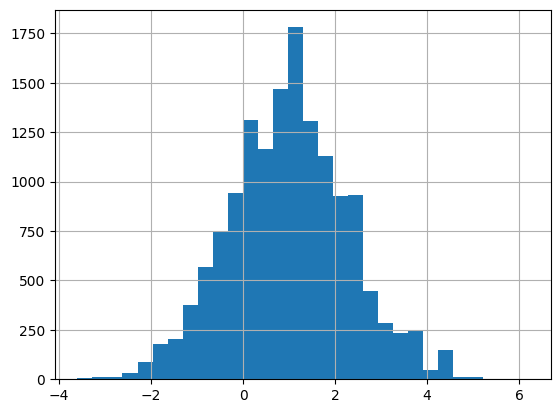

In [3]:
# 목적 변수 분포
logP_data.logP.hist(bins=30)

## SMILES로부터 Mol 객체 얻기
- Chem.MolFromSmiles() 함수를 이용한다

In [4]:
# 사본 데이터프레임 사용
df = logP_data.copy() 

In [5]:
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

# 다른 방법
# df['mol'] = [Chem.MolFromSmiles(x) for x in df['smiles']] 
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


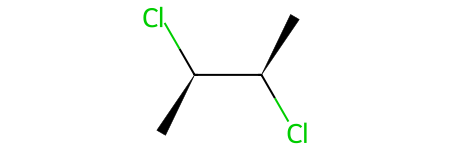

In [6]:
df.mol[0]

## 시각화
- rdkit.Chem.Draw를 사용하여 mol 객체를 시각화할 수 있다
- Draw.MolsToGridImage()함수 사용

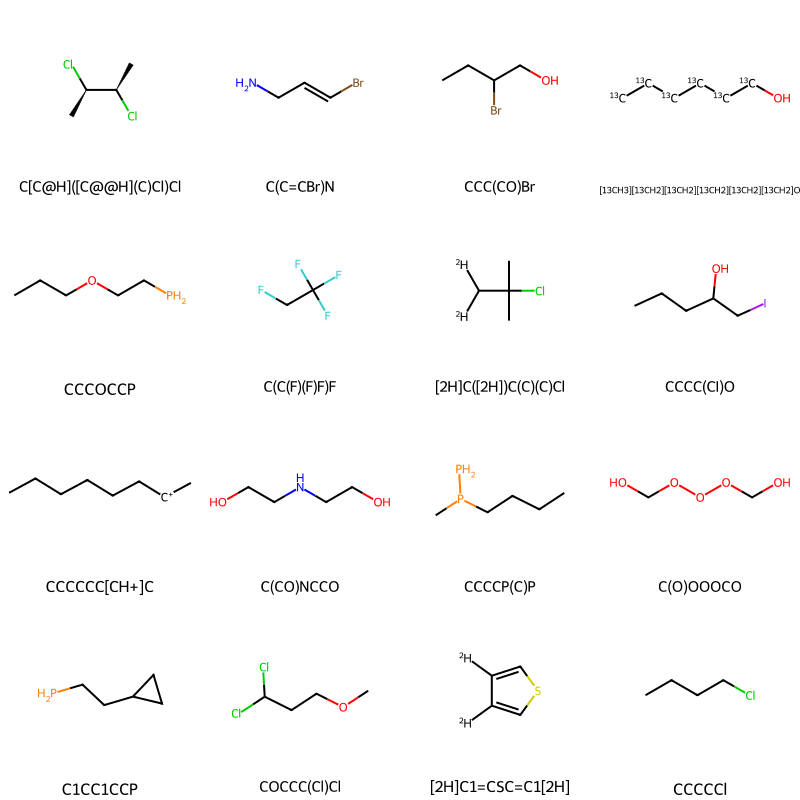

In [7]:
# 16개 이미지를 그리드 형태로 그리기
mols = df['mol'][:16]
Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=list(df['smiles'][:16].values))

## 분자 정보 보기

- Chem 모듈에서 다양한 정보 추출 함수를 제공한다
- 예를 들어 mol 객체로부터 분자를 구성하는 원자수를 얻으려면 다음과 같은 함수를 사용하면 된다
 - GetNumAtoms()
 - GetNumHeavyAtoms()
- mol 객체에 수소원자를 포함시키려면 AddHs()를 호출한다


In [8]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce18c0>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce1c40>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce1cb0>,15,6


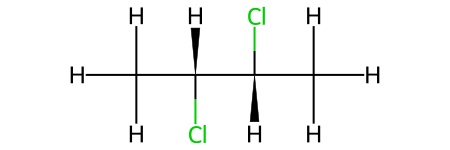

In [9]:
df.mol[0]

## 특성 추가
- 분자내에 들어 있는 C, O 등 각 원자별 갯수를 특성으로 추가하겠다
- 이를 위해서 분자의 하부 구성을 찾는 GetSubstructMatches()를 사용한다

In [10]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (2,), (3,))


In [11]:
# 임의의 패턴(원자)를 몇개 포함하고 있는지를 얻는 함수
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

In [12]:
df[:3]

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce18c0>,14,6,4,0,0,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce1c40>,11,5,3,0,1,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7fb534ce1cb0>,15,6,4,1,0,0


# 회귀 모델
- 위에서 구한 분자의 여러 특성을 사용하여 용해도를 예측한다

## 훈련/검증 데이터 나누기


In [13]:
# 특성 컬럼을 선택하여 X를 만들고 목적변수를 정의한다
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)

# 훈련과 검증 데이터를 나눈다 (검증 데이터로 10% 할당)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1)


Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')


In [14]:
def show_reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    R2 = r2_score(y_test, y_pred)
    max_err = np.abs(y_test - y_pred).max()
    
    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)
    
    if N > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
        plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
        plt.legend()
        plt.ylabel('logP')
        plt.show()  

## 선형모델

In [15]:
X_train.columns

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')

R2: 0.6541
MAE: 0.593
RMSE: 0.7807
Max error: 4.8726


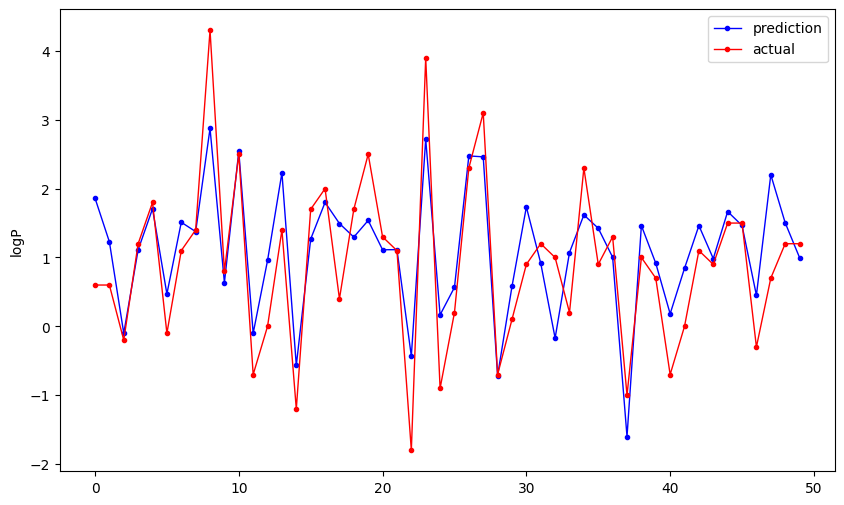

In [103]:
# 모델 학습 및 성능 평가
lin = LinearRegression() # y = ax + b
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test) # logP의 예측값
show_reg_result(y_test, y_pred)

### 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치
 
-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [104]:
lin.coef_

array([-0.15538238,  0.41748878,  0.39940633, -0.72816512, -0.81485341,
        0.1286548 ])

## 연합학습 simulation 코드
- 연합학습 실험을 위해 여러 장치 혹은 여러 프로그램을 실행하지 않고 가상 클라이언트를 생성하여 연합학습 결과를 확인할 수 있는 기능

In [91]:
# 하나의 리스트를 n개로 분할하는 함수 정의
import math
def list_split(arr, n):
    num = math.ceil(len(arr) / n)
    return [arr[i: i + num] for i in range(0, len(arr), num)]

In [92]:
num_clients = 40
x_train_list, y_train_list = map(list_split, (X_train, y_train), (num_clients, num_clients))
x_val_list, y_val_list = map(list_split, (X_test, y_test), (num_clients, num_clients))

- sklearn 모델에는 TensorFlow나 Pytorch처럼 모델의 파라미터를 반환하고 입력하는 함수가 없음
- 아래의 함수는 sklearn의 LinearRegression 혹은 LogisticRegression의 가중치를 설정하는 함수 (flower 문서에서 제공)

In [130]:
def get_model_parameters(model):
    if model.fit_intercept:
        params = [
            model.coef_,
            model.intercept_,
        ]
    else:
        params = [
            model.coef_,
        ]
    return params


def set_model_params(
    model, params
):
    model.coef_ = params[0]
    if model.fit_intercept:
        model.intercept_ = params[1]
    return model


def set_initial_params(model, n_features, n_classes):
    model.classes_ = np.array([i for i in range(n_classes)])

    model.coef_ = np.zeros((n_classes, n_features))
    if model.fit_intercept:
        model.intercept_ = np.zeros((n_classes,))

In [131]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_val, y_val):
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        set_initial_params(self.model, len(self.y_train), len(self.x_train))
        
    def get_parameters(self, config):  # type: ignore
        return get_model_parameters(self.model)

    def fit(self, parameters, config):  # type: ignore
        set_model_params(self.model, parameters)
        self.model.fit(self.x_train, self.y_train)
        return get_model_parameters(self.model), len(self.x_train), {}

    def evaluate(self, parameters, config):  # type: ignore
        set_model_params(self.model, parameters)
        y_pred = lin.predict(self.x_val)
        mae = mean_absolute_error(self.y_val, y_pred)
        rmse = mean_squared_error(self.y_val, y_pred, squared=False)
        R2 = r2_score(self.y_val, y_pred)
        max_err = np.abs(self.y_val - y_pred).max()
        
        accuracy = self.model.score(self.x_val, self.y_val)
        return mae, len(self.x_val), {"mae": mae, "rmse": rmse, "R2": R2, "max_err": max_err, "accuracy": accuracy}

- 가상 클라이언트를 생성할 때 각 클라이언트가 소유할 데이터와 모델을 지정하여 FlowerClinet 생성

In [132]:
def client_fn(cid: str) -> fl.client.Client:
    # model 정의
    model = LinearRegression()
    
    # cid 값이 문자열로 입력되기에 이를 정수형으로 변환
    num = int(cid)
    # 위 셀에서 분할한 데이터셋을 클라이언트 번호에 맞게 변수로 저장
    x_train_cid, y_train_cid, x_val_cid, y_val_cid = x_train_list[num], y_train_list[num], x_val_list[num], y_val_list[num]
    
    # 번호에 맞는 클라이언트 클래스 생성하여 반환
    return FlowerClient(model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

- 여러 성능지표를 집계하는 함수

In [133]:
def evaluate_metrics_aggregation_fn(eval_metrics):
    data_len = sum([num for num, met in eval_metrics])
    mae = sum([num*met['mae'] for num, met in eval_metrics])/data_len
    rmse = sum([num*met['rmse'] for num, met in eval_metrics])/data_len # 정확한 계산이 아님
    R2 = sum([num*met['R2'] for num, met in eval_metrics])/data_len # 정확한 계산이 아님
    max_err = np.abs([met['max_err'] for num, met in eval_metrics]).max()
    accuracy = sum([num*met['accuracy'] for num, met in eval_metrics])/data_len
    return {"mae": mae, "rmse": rmse, "R2": R2, "max_err": max_err, "accuracy" : accuracy}

In [134]:
# FedAvg strategy 생성
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # 라운드마다 학습을 진행할 클라이언트 비율 [0 ~ 1]
    fraction_evaluate=1,  # 라운드마다 평가를 진행할 클라이언트 비율[0 ~ 1]
    min_fit_clients=40,  # 라운드마다 학습을 진행할 최소 클라이언트 수 [정수]
    min_evaluate_clients=40,  # 라운드마다 평가를 진행할 최소 클라이언트 수 [정수]
    min_available_clients=40,  # 연합학습을 진행하기 위해 필요한 최소 클라이언트 수 [정수]
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn, # 집계된 성능 지표 계산 함수 (다른 예제에서 자세히 설명)
)

# simulation 시작 코드
output = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
)
output

INFO flwr 2023-09-13 13:07:14,922 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-13 13:07:18,527	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-13 13:07:19,461 | app.py:210 | Flower VCE: Ray initialized with resources: {'object_store_memory': 68258376499.0, 'CPU': 36.0, 'GPU': 4.0, 'node:__internal_head__': 1.0, 'memory': 149269545165.0, 'node:10.11.63.239': 1.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-09-13 13:07:19,462 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-13 13:07:19,462 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-09-13 13:07:19,480 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 36 actors
INFO flwr 2023-09-13 13:07:19,481 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-13 13:07:19,482 | server.py:276 | Requesting initial parame

DEBUG flwr 2023-09-13 13:07:32,979 | server.py:222 | fit_round 6: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:07:33,828 | server.py:236 | fit_round 6 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:07:33,850 | server.py:173 | evaluate_round 6: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:07:34,830 | server.py:187 | evaluate_round 6 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:07:34,832 | server.py:222 | fit_round 7: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:07:35,656 | server.py:236 | fit_round 7 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:07:35,677 | server.py:173 | evaluate_round 7: strategy sampled 40 clients (out of 40)
(DefaultActor pid=2286853) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names [repeated 120x across cluster]
(DefaultActor pid=2286853)

History (loss, distributed):
	round 1: 0.5930147413648895
	round 2: 0.5930147413648897
	round 3: 0.5930147413648896
	round 4: 0.5930147413648895
	round 5: 0.5930147413648899
	round 6: 0.5930147413648895
	round 7: 0.5930147413648897
	round 8: 0.5930147413648896
	round 9: 0.5930147413648897
	round 10: 0.5930147413648895
History (metrics, distributed, evaluate):
{'mae': [(1, 0.5930147413648895), (2, 0.5930147413648897), (3, 0.5930147413648896), (4, 0.5930147413648895), (5, 0.5930147413648899), (6, 0.5930147413648895), (7, 0.5930147413648897), (8, 0.5930147413648896), (9, 0.5930147413648897), (10, 0.5930147413648895)], 'rmse': [(1, 0.7718327052211851), (2, 0.771832705221185), (3, 0.7718327052211853), (4, 0.7718327052211853), (5, 0.7718327052211851), (6, 0.7718327052211851), (7, 0.7718327052211851), (8, 0.7718327052211851), (9, 0.771832705221185), (10, 0.7718327052211853)], 'R2': [(1, 0.6322243256355813), (2, 0.6322243256355814), (3, 0.6322243256355814), (4, 0.6322243256355814), (5, 0.63222

In [135]:
pd.DataFrame(output.metrics_distributed)

,mae,rmse,R2,max_err,accuracy
0,"(1, 0.5930147413648895)","(1, 0.7718327052211851)","(1, 0.6322243256355813)","(1, 4.872613314388602)","(1, 0.6317740290239469)"
1,"(2, 0.5930147413648897)","(2, 0.771832705221185)","(2, 0.6322243256355814)","(2, 4.872613314388602)","(2, 0.6317740290239467)"
2,"(3, 0.5930147413648896)","(3, 0.7718327052211853)","(3, 0.6322243256355814)","(3, 4.872613314388602)","(3, 0.631774029023947)"
3,"(4, 0.5930147413648895)","(4, 0.7718327052211853)","(4, 0.6322243256355814)","(4, 4.872613314388602)","(4, 0.6317740290239469)"
4,"(5, 0.5930147413648899)","(5, 0.7718327052211851)","(5, 0.6322243256355813)","(5, 4.872613314388602)","(5, 0.631774029023947)"
5,"(6, 0.5930147413648895)","(6, 0.7718327052211851)","(6, 0.6322243256355814)","(6, 4.872613314388602)","(6, 0.631774029023947)"
6,"(7, 0.5930147413648897)","(7, 0.7718327052211851)","(7, 0.6322243256355814)","(7, 4.872613314388602)","(7, 0.631774029023947)"
7,"(8, 0.5930147413648896)","(8, 0.7718327052211851)","(8, 0.6322243256355814)","(8, 4.872613314388602)","(8, 0.6317740290239469)"
8,"(9, 0.5930147413648897)","(9, 0.771832705221185)","(9, 0.6322243256355814)","(9, 4.872613314388602)","(9, 0.631774029023947)"
9,"(10, 0.5930147413648895)","(10, 0.7718327052211853)","(10, 0.6322243256355814)","(10, 4.872613314388602)","(10, 0.631774029023947)"


(DefaultActor pid=2286842) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
(DefaultActor pid=2286842)   warnings.warn(


## 분자 특성 추가

- [rdkit.Chem.Descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html)이 제공하는 함수들을 사용하면 다양한 분자특성들을 알 수 있다. 아래의 특성을 추가하겠다

 - TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;
 - ExactMolWt() - 정확한 몰 중량
 - NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)
 - NumHeteroatoms() - general number of non-carbon atoms
 
- 이외에도 분자의 링정보를 보거나, 원자별로 결합 정보를 볼 수 있다
 - GetRingInfo(), GetAtoms(), GetBonds() 등을 사용

In [136]:
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

- 특성을 추가했을 때의 성능을 비교하겠다

In [137]:
train_df = df.drop(columns=['smiles', 'mol', 'logP'])
y = df['logP'].values

print(train_df.columns)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.1, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


In [138]:
X_train.shape

(13149, 10)

R2: 0.7907
MAE: 0.4625
RMSE: 0.5932
Max error: 2.2606


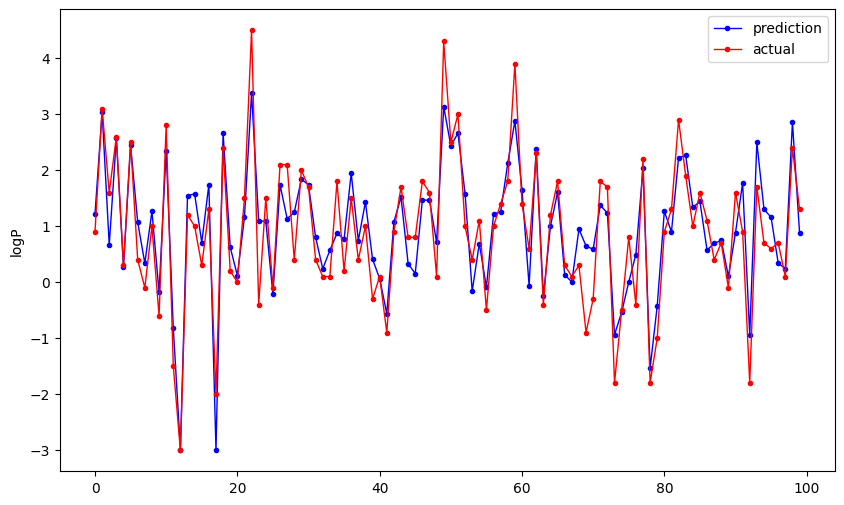

In [139]:
lin = LinearRegression() # y = ax + b
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred,100)

In [140]:
lin.coef_ # y = ax +b

array([-0.29776277, -0.60021523,  0.15722981, -0.03826434,  0.12643248,
        0.07375684, -0.03395185,  0.00498247,  0.26900081, -0.75744504])

In [141]:
# 선형 모델 가중치를 보는 함수 정의

def plot_feature_weight(feature, weight):
    # plt.figure(figsize=(5,8)) # 특성수가 많은 경우
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

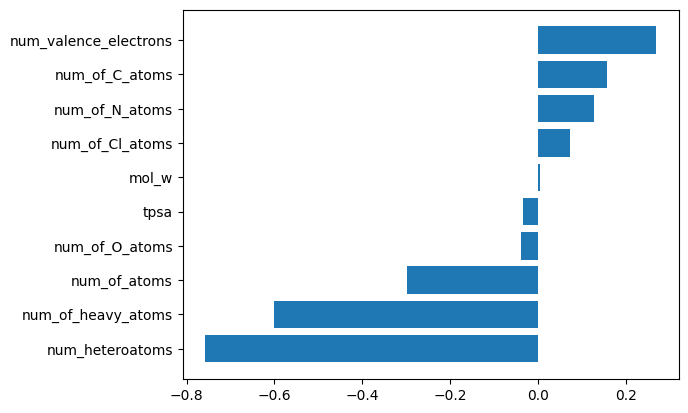

In [142]:
plot_feature_weight(train_df.columns, lin.coef_)

## 연합학습 simulation 코드

In [143]:
num_clients = 40
x_train_list, y_train_list = map(list_split, (X_train, y_train), (num_clients, num_clients))
x_val_list, y_val_list = map(list_split, (X_test, y_test), (num_clients, num_clients))

# FedAvg strategy 생성
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # 라운드마다 학습을 진행할 클라이언트 비율 [0 ~ 1]
    fraction_evaluate=1,  # 라운드마다 평가를 진행할 클라이언트 비율[0 ~ 1]
    min_fit_clients=40,  # 라운드마다 학습을 진행할 최소 클라이언트 수 [정수]
    min_evaluate_clients=40,  # 라운드마다 평가를 진행할 최소 클라이언트 수 [정수]
    min_available_clients=40,  # 연합학습을 진행하기 위해 필요한 최소 클라이언트 수 [정수]
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn, # 집계된 성능 지표 계산 함수 (다른 예제에서 자세히 설명)
)

# simulation 시작 코드
output = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
)
output

INFO flwr 2023-09-13 13:10:30,103 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-13 13:10:33,730	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-13 13:10:34,718 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 149262695424.0, 'GPU': 4.0, 'object_store_memory': 68255440896.0, 'accelerator_type:RTX': 1.0, 'node:10.11.63.239': 1.0, 'node:__internal_head__': 1.0, 'CPU': 36.0}
INFO flwr 2023-09-13 13:10:34,719 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-13 13:10:34,720 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-09-13 13:10:34,756 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 36 actors
INFO flwr 2023-09-13 13:10:34,758 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-13 13:10:34,759 | server.py:276 | Requesting initial parame

(DefaultActor pid=2293982) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names [repeated 90x across cluster]
(DefaultActor pid=2293982)   warnings.warn( [repeated 90x across cluster]
DEBUG flwr 2023-09-13 13:10:51,690 | server.py:187 | evaluate_round 6 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:10:51,691 | server.py:222 | fit_round 7: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:10:52,647 | server.py:236 | fit_round 7 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:10:52,669 | server.py:173 | evaluate_round 7: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:10:53,630 | server.py:187 | evaluate_round 7 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:10:53,632 | server.py:222 | fit_round 8: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:10:54,558 | server.py:236 | fit_ro

History (loss, distributed):
	round 1: 0.4624559710933835
	round 2: 0.4624559710933833
	round 3: 0.4624559710933834
	round 4: 0.4624559710933834
	round 5: 0.4624559710933834
	round 6: 0.46245597109338327
	round 7: 0.4624559710933834
	round 8: 0.4624559710933834
	round 9: 0.4624559710933835
	round 10: 0.4624559710933833
History (metrics, distributed, evaluate):
{'mae': [(1, 0.4624559710933835), (2, 0.4624559710933833), (3, 0.4624559710933834), (4, 0.4624559710933834), (5, 0.4624559710933834), (6, 0.46245597109338327), (7, 0.4624559710933834), (8, 0.4624559710933834), (9, 0.4624559710933835), (10, 0.4624559710933833)], 'rmse': [(1, 0.5894811614954651), (2, 0.5894811614954651), (3, 0.589481161495465), (4, 0.5894811614954651), (5, 0.5894811614954651), (6, 0.5894811614954651), (7, 0.5894811614954651), (8, 0.5894811614954651), (9, 0.5894811614954651), (10, 0.5894811614954653)], 'R2': [(1, 0.7776991791528505), (2, 0.7776991791528505), (3, 0.7776991791528503), (4, 0.7776991791528503), (5, 0.77

In [144]:
pd.DataFrame(output.metrics_distributed)

(DefaultActor pid=2293992) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
(DefaultActor pid=2293992)   warnings.warn(


,mae,rmse,R2,max_err,accuracy
0,"(1, 0.4624559710933835)","(1, 0.5894811614954651)","(1, 0.7776991791528505)","(1, 2.26057058532745)","(1, 0.7778863432302274)"
1,"(2, 0.4624559710933833)","(2, 0.5894811614954651)","(2, 0.7776991791528505)","(2, 2.26057058532745)","(2, 0.7778863432302274)"
2,"(3, 0.4624559710933834)","(3, 0.589481161495465)","(3, 0.7776991791528503)","(3, 2.26057058532745)","(3, 0.7778863432302273)"
3,"(4, 0.4624559710933834)","(4, 0.5894811614954651)","(4, 0.7776991791528503)","(4, 2.26057058532745)","(4, 0.7778863432302273)"
4,"(5, 0.4624559710933834)","(5, 0.5894811614954651)","(5, 0.7776991791528505)","(5, 2.26057058532745)","(5, 0.7778863432302273)"
5,"(6, 0.46245597109338327)","(6, 0.5894811614954651)","(6, 0.7776991791528503)","(6, 2.26057058532745)","(6, 0.7778863432302272)"
6,"(7, 0.4624559710933834)","(7, 0.5894811614954651)","(7, 0.7776991791528505)","(7, 2.26057058532745)","(7, 0.7778863432302277)"
7,"(8, 0.4624559710933834)","(8, 0.5894811614954651)","(8, 0.7776991791528501)","(8, 2.26057058532745)","(8, 0.7778863432302274)"
8,"(9, 0.4624559710933835)","(9, 0.5894811614954651)","(9, 0.7776991791528503)","(9, 2.26057058532745)","(9, 0.7778863432302274)"
9,"(10, 0.4624559710933833)","(10, 0.5894811614954653)","(10, 0.7776991791528503)","(10, 2.26057058532745)","(10, 0.7778863432302273)"


# Fingerprint 표현형 사용

- mol 객체로부터 ECFP Fingerprint를 구하는 함수 정의
- GetMorganFingerprintAsBitVect() 함수를 사용한다

In [38]:
def mol_2_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    # fp_arr = np.zeros((1, ), dtype=np.int8)
    # DataStructs.ConvertToNumpyArray(fp, fp_arr)
    # return fp_arr
    return fp

- 분자별 Fingerprint 정보를 2차원 어레이로 만들기
- 여러 어레이를 합치기 위해서 np.vstack()을 사용한다

In [41]:
list_fp = df['mol'].apply(mol_2_fp)
ecfp = np.vstack(list_fp)
print(ecfp.shape)
ecfp[:3]

(14610, 1024)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

- Fingerprint를 사용한 경우의 모델 성능 보기

In [42]:
X_train, X_test, y_train, y_test = train_test_split(ecfp, y, test_size=.1)

R2: 0.764
MAE: 0.474
RMSE: 0.6254
Max error: 3.2672


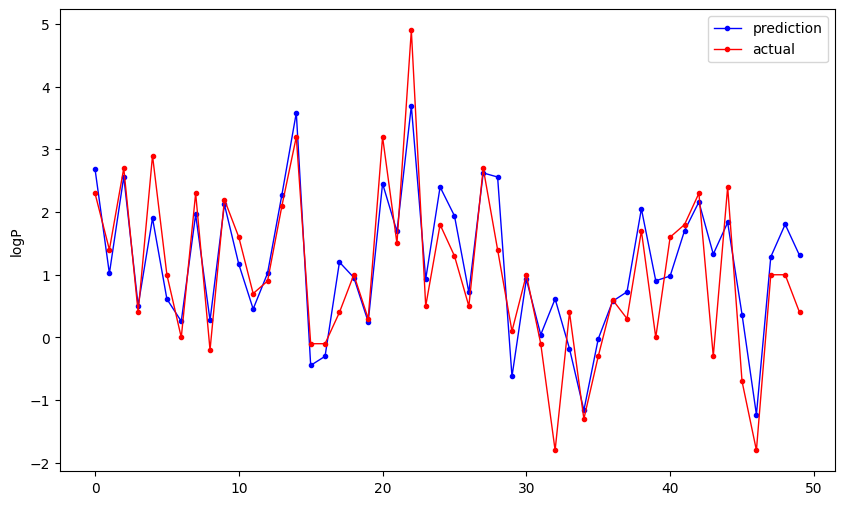

In [43]:
lin = LinearRegression() # y = ax + b
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred)

## 연합학습 simulation 코드

In [145]:
num_clients = 40
x_train_list, y_train_list = map(list_split, (X_train, y_train), (num_clients, num_clients))
x_val_list, y_val_list = map(list_split, (X_test, y_test), (num_clients, num_clients))

# FedAvg strategy 생성
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # 라운드마다 학습을 진행할 클라이언트 비율 [0 ~ 1]
    fraction_evaluate=1,  # 라운드마다 평가를 진행할 클라이언트 비율[0 ~ 1]
    min_fit_clients=40,  # 라운드마다 학습을 진행할 최소 클라이언트 수 [정수]
    min_evaluate_clients=40,  # 라운드마다 평가를 진행할 최소 클라이언트 수 [정수]
    min_available_clients=40,  # 연합학습을 진행하기 위해 필요한 최소 클라이언트 수 [정수]
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn, # 집계된 성능 지표 계산 함수 (다른 예제에서 자세히 설명)
)

# simulation 시작 코드
output = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
)
output

INFO flwr 2023-09-13 13:13:20,358 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-09-13 13:13:23,998	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-13 13:13:24,995 | app.py:210 | Flower VCE: Ray initialized with resources: {'accelerator_type:RTX': 1.0, 'node:10.11.63.239': 1.0, 'GPU': 4.0, 'object_store_memory': 68247655219.0, 'memory': 149244528845.0, 'CPU': 36.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-09-13 13:13:24,996 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-13 13:13:24,996 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2023-09-13 13:13:25,027 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 36 actors
INFO flwr 2023-09-13 13:13:25,029 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-13 13:13:25,030 | server.py:276 | Requesting initial parame

(DefaultActor pid=2300538) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names [repeated 112x across cluster]
(DefaultActor pid=2300538)   warnings.warn( [repeated 112x across cluster]
DEBUG flwr 2023-09-13 13:13:41,490 | server.py:187 | evaluate_round 6 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:13:41,492 | server.py:222 | fit_round 7: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:13:42,587 | server.py:236 | fit_round 7 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:13:42,610 | server.py:173 | evaluate_round 7: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:13:43,540 | server.py:187 | evaluate_round 7 received 40 results and 0 failures
DEBUG flwr 2023-09-13 13:13:43,542 | server.py:222 | fit_round 8: strategy sampled 40 clients (out of 40)
DEBUG flwr 2023-09-13 13:13:44,526 | server.py:236 | fit_

History (loss, distributed):
	round 1: 0.4624559710933833
	round 2: 0.4624559710933833
	round 3: 0.46245597109338327
	round 4: 0.46245597109338316
	round 5: 0.46245597109338327
	round 6: 0.46245597109338354
	round 7: 0.4624559710933835
	round 8: 0.4624559710933833
	round 9: 0.4624559710933833
	round 10: 0.4624559710933833
History (metrics, distributed, evaluate):
{'mae': [(1, 0.4624559710933833), (2, 0.4624559710933833), (3, 0.46245597109338327), (4, 0.46245597109338316), (5, 0.46245597109338327), (6, 0.46245597109338354), (7, 0.4624559710933835), (8, 0.4624559710933833), (9, 0.4624559710933833), (10, 0.4624559710933833)], 'rmse': [(1, 0.5894811614954651), (2, 0.5894811614954651), (3, 0.5894811614954651), (4, 0.5894811614954649), (5, 0.5894811614954653), (6, 0.5894811614954651), (7, 0.589481161495465), (8, 0.5894811614954651), (9, 0.589481161495465), (10, 0.5894811614954651)], 'R2': [(1, 0.7776991791528506), (2, 0.7776991791528503), (3, 0.7776991791528505), (4, 0.7776991791528503), (5,

In [146]:
pd.DataFrame(output.metrics_distributed)

,mae,rmse,R2,max_err,accuracy
0,"(1, 0.4624559710933833)","(1, 0.5894811614954651)","(1, 0.7776991791528506)","(1, 2.26057058532745)","(1, 0.7778863432302273)"
1,"(2, 0.4624559710933833)","(2, 0.5894811614954651)","(2, 0.7776991791528503)","(2, 2.26057058532745)","(2, 0.7778863432302273)"
2,"(3, 0.46245597109338327)","(3, 0.5894811614954651)","(3, 0.7776991791528505)","(3, 2.26057058532745)","(3, 0.7778863432302274)"
3,"(4, 0.46245597109338316)","(4, 0.5894811614954649)","(4, 0.7776991791528503)","(4, 2.26057058532745)","(4, 0.7778863432302274)"
4,"(5, 0.46245597109338327)","(5, 0.5894811614954653)","(5, 0.7776991791528501)","(5, 2.26057058532745)","(5, 0.7778863432302274)"
5,"(6, 0.46245597109338354)","(6, 0.5894811614954651)","(6, 0.7776991791528503)","(6, 2.26057058532745)","(6, 0.7778863432302277)"
6,"(7, 0.4624559710933835)","(7, 0.589481161495465)","(7, 0.7776991791528503)","(7, 2.26057058532745)","(7, 0.7778863432302274)"
7,"(8, 0.4624559710933833)","(8, 0.5894811614954651)","(8, 0.7776991791528505)","(8, 2.26057058532745)","(8, 0.7778863432302273)"
8,"(9, 0.4624559710933833)","(9, 0.589481161495465)","(9, 0.77769917915285)","(9, 2.26057058532745)","(9, 0.7778863432302273)"
9,"(10, 0.4624559710933833)","(10, 0.5894811614954651)","(10, 0.7776991791528501)","(10, 2.26057058532745)","(10, 0.7778863432302274)"


(DefaultActor pid=2300556) /home/dilab239/anaconda3/envs/AI_study/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
(DefaultActor pid=2300556)   warnings.warn(
